In [5]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [15]:
# Cargar las stopwords en inglés
stop_words = set(stopwords.words('english'))


In [16]:

# Cargar el dataset
df = pd.read_csv("amazon.csv")

In [17]:
# Seleccionar solo las columnas necesarias
df = df[['review_content', 'rating']].copy()

# Convertir la columna de rating a numérico
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Eliminar valores nulos
df = df.dropna(subset=['review_content', 'rating'])




In [18]:
# Convertir rating en etiquetas de sentimiento
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

In [19]:
# Función de limpieza de texto
def clean_text(text):
    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales y puntuación
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenizar palabras
    words = text.split()
    # Eliminar stopwords
    words = [word for word in words if word not in stop_words]
    # Unir palabras limpias en una sola cadena
    return ' '.join(words)


In [20]:
# Aplicar la limpieza de texto a las reseñas
df['clean_review'] = df['review_content'].apply(clean_text)


In [21]:
# Mostrar las primeras filas del dataset limpio
print(df[['review_content', 'clean_review', 'sentiment']].head())

                                      review_content  \
0  Looks durable Charging is fine tooNo complains...   
1  I ordered this cable to connect my phone to An...   
2  Not quite durable and sturdy,https://m.media-a...   
3  Good product,long wire,Charges good,Nice,I bou...   
4  Bought this instead of original apple, does th...   

                                        clean_review sentiment  
0  looks durable charging fine toono complainscha...  positive  
1  ordered cable connect phone android auto car c...  positive  
2  quite durable sturdyhttpsmmediaamazoncomimages...  negative  
3  good productlong wirecharges goodnicei bought ...  positive  
4  bought instead original apple work rs fast app...  positive  


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(df['review_content'], df['sentiment'], test_size=0.2, random_state=42)

In [28]:
# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)


In [29]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [13]:
# Convertir la matriz a DataFrame para visualizar mejor
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [30]:
# Definir modelos y parámetros para GridSearch
modelos = {
    "Regresión Logística": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

hiperparametros = {
    "Regresión Logística": {'C': [0.01, 0.1, 1, 10]},
    "Naive Bayes": {'alpha': [0.1, 0.5, 1]},
    "Random Forest": {'n_estimators': [50, 100, 200]},
    "SVM": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

In [31]:
# Entrenamiento y evaluación de modelos
resultados = {}
for nombre, modelo in modelos.items():
    print(f"Entrenando {nombre}...")
    inicio = time.time()
    
    grid = GridSearchCV(modelo, hiperparametros[nombre], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_tfidf, y_train)
    
    mejor_modelo = grid.best_estimator_
    y_pred = mejor_modelo.predict(X_test_tfidf)
    
    resultados[nombre] = {
        "Mejores Parámetros": grid.best_params_,
        "Precisión": accuracy_score(y_test, y_pred),
        "Reporte": classification_report(y_test, y_pred),
        "Matriz de Confusión": confusion_matrix(y_test, y_pred),
        "Tiempo de Entrenamiento": time.time() - inicio
    }
    
    print(f"{nombre} - Precisión: {resultados[nombre]['Precisión']:.4f}, Mejores Parámetros: {resultados[nombre]['Mejores Parámetros']}")
    print(resultados[nombre]['Reporte'])
    print("-"*50)



Entrenando Regresión Logística...
Regresión Logística - Precisión: 0.8020, Mejores Parámetros: {'C': 10}
              precision    recall  f1-score   support

    negative       0.74      0.34      0.46        74
    positive       0.81      0.96      0.88       219

    accuracy                           0.80       293
   macro avg       0.77      0.65      0.67       293
weighted avg       0.79      0.80      0.77       293

--------------------------------------------------
Entrenando Naive Bayes...
Naive Bayes - Precisión: 0.7577, Mejores Parámetros: {'alpha': 0.1}
              precision    recall  f1-score   support

    negative       0.67      0.08      0.14        74
    positive       0.76      0.99      0.86       219

    accuracy                           0.76       293
   macro avg       0.71      0.53      0.50       293
weighted avg       0.74      0.76      0.68       293

--------------------------------------------------
Entrenando Random Forest...
Random Forest - P

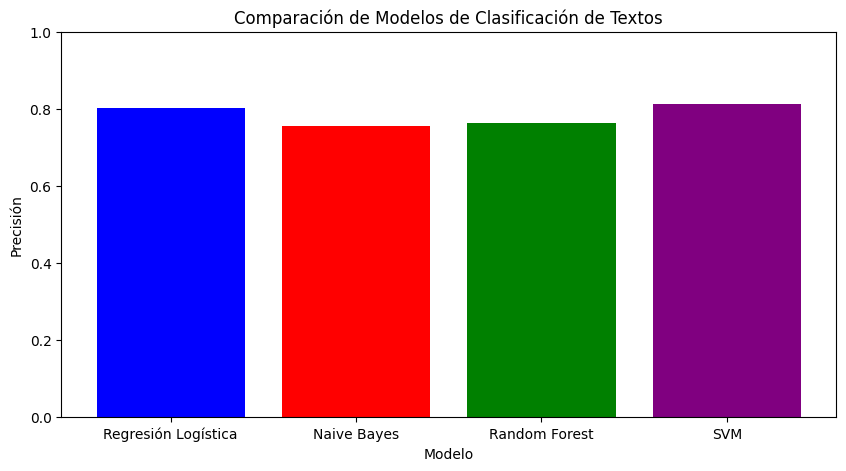

In [35]:
# Visualización de resultados
plt.figure(figsize=(10, 5))
precisiones = [resultados[m]['Precisión'] for m in resultados]
plt.bar(resultados.keys(), precisiones, color=['blue', 'red', 'green', 'purple'])
plt.xlabel('Modelo')
plt.ylabel('Precisión')
plt.title('Comparación de Modelos de Clasificación de Textos')
plt.ylim(0, 1)
plt.savefig("Comparación de Modelos de Clasificación de Textos.png", dpi=300)
plt.show()

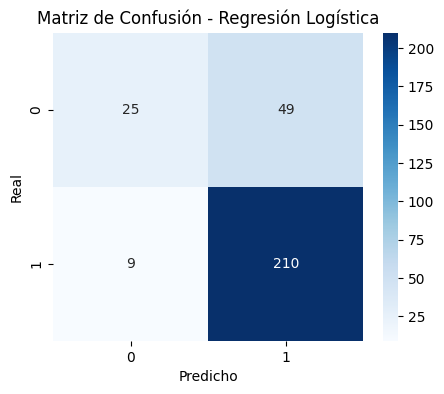

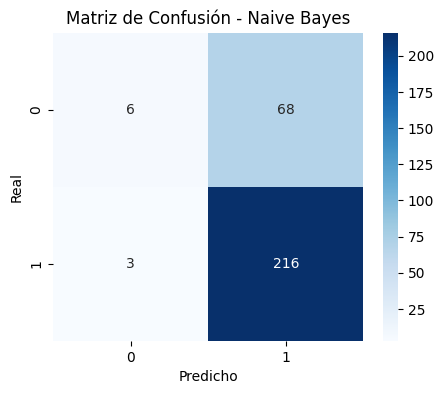

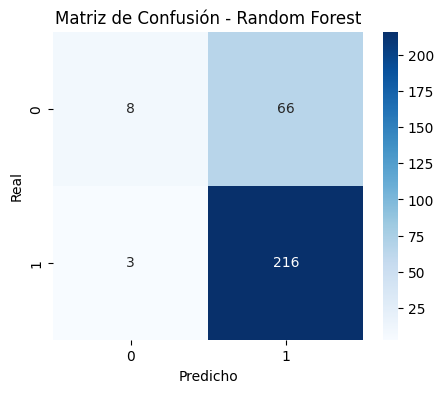

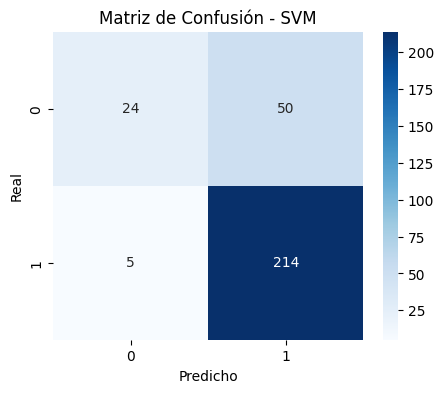

In [36]:
for nombre in resultados:
    plt.figure(figsize=(5, 4))
    sns.heatmap(resultados[nombre]["Matriz de Confusión"], annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.savefig(f'Matriz de Confusión - {nombre}.png', dpi=300)

    plt.show()

# Guardar resultados
df_resultados = pd.DataFrame({
    "Modelo": resultados.keys(),
    "Precisión": [resultados[m]['Precisión'] for m in resultados],
    "Mejor Parámetro": [str(resultados[m]['Mejores Parámetros']) for m in resultados],
    "Tiempo de Entrenamiento": [resultados[m]['Tiempo de Entrenamiento'] for m in resultados]
})


In [34]:
df_resultados.to_csv('resultados_experimentos.csv', index=False)
